# Import Library

In [1]:
import json
import random
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Embedding, LSTM
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import load_model

# Cleaning Data

In [5]:
file_path = "/kaggle/input/mentalhealth/mental.json"
with open(file_path) as file:
    data = json.load(file)

patterns = []
tags = []
responses = {}

for intent in data['intents']:
    for pattern in intent['patterns']:
        patterns.append(pattern)
        tags.append(intent['tag'])
    responses[intent['tag']] = intent['responses']

# Convert to DataFrame for easier manipulation
df = pd.DataFrame({'patterns': patterns, 'tags': tags})

# Display before cleaning
print("Before Cleaning:")
print(df['patterns'].head(10))

# Data Cleaning
# Convert to lowercase
df['patterns'] = df['patterns'].str.lower()

# Remove punctuation and special characters
df['patterns'] = df['patterns'].str.replace('[^\w\s]', '', regex=True)

# Remove any leading/trailing whitespace
df['patterns'] = df['patterns'].str.strip()

# Check for and remove duplicates
df.drop_duplicates(inplace=True)

# Check for and handle missing values if any
df.dropna(inplace=True)

# Extract cleaned patterns and tags
cleaned_patterns = df['patterns'].tolist()
cleaned_tags = df['tags'].tolist()

# Display after cleaning
print("\nAfter Cleaning:")
print(cleaned_patterns[:10])


Before Cleaning:
0                  Hi
1                 Hey
2    Is anyone there?
3            Hi there
4               Hello
5           Hey there
6               Howdy
7                Hola
8             Bonjour
9          Konnichiwa
Name: patterns, dtype: object

After Cleaning:
['hi', 'hey', 'is anyone there', 'hi there', 'hello', 'hey there', 'howdy', 'hola', 'bonjour', 'konnichiwa']


# Architecting Model

/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/170
29/29 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.0464 - loss: 4.3578
Epoch 2/170
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.0426 - loss: 4.1702 
Epoch 3/170
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.0449 - loss: 4.0042 
Epoch 4/170
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.0612 - loss: 4.0418
Epoch 5/170
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.0288 - loss: 4.1508 
Epoch 6/170
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.0471 - loss: 4.1148
Epoch 7/170
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.0742 - loss: 4.0688
Epoch 8/170
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.0556 - loss: 4.0985 
Epoch 9/170
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.0586 - loss: 4.0500 
Epoch 10/170
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.0473 - loss: 4.0294
Epoch 11/170
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.0379 - loss: 3.9128 
Epoch 12/170
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - acc

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (8, 18, 16)            │        16,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (8, 18, 32)            │         6,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (8, 18, 32)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (8, 32)                │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (8, 32)                │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (8, 80)                │         2,640 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 102,866 (401.82 KB)

 Trainable params: 34,288 (133.94 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 68,578 (267.89 KB)

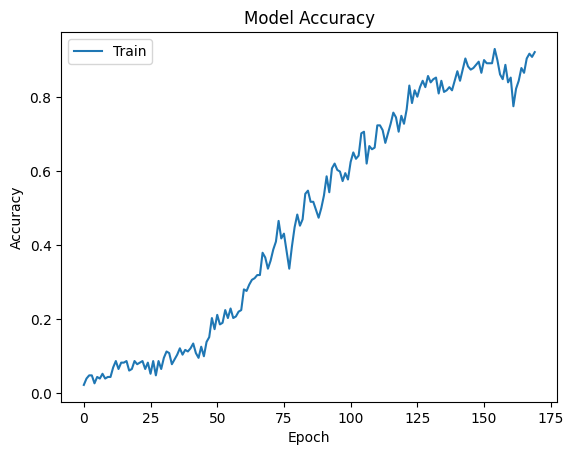

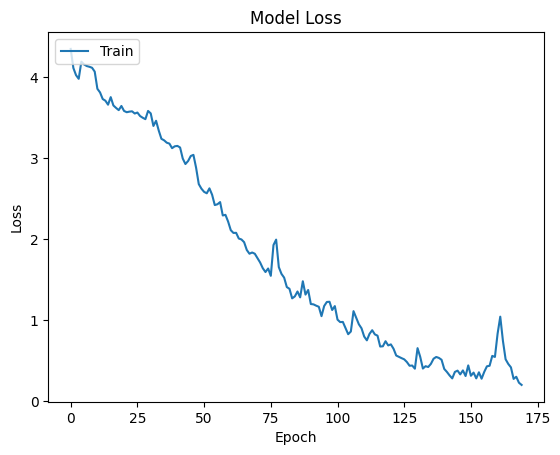

In [6]:
# Encode the tags
label_encoder = LabelEncoder()
encoded_tags = label_encoder.fit_transform(tags)

# Tokenize the patterns
tokenizer = Tokenizer(num_words=1000, oov_token="<OOV>")
tokenizer.fit_on_texts(patterns)
word_index = tokenizer.word_index
sequences = tokenizer.texts_to_sequences(patterns)
padded_sequences = pad_sequences(sequences, padding="post")

# Prepare input and output data
input_data = np.array(padded_sequences)
output_data = tf.keras.utils.to_categorical(encoded_tags)

# Build the model
model = Sequential([
    Embedding(input_dim=1000, output_dim=16, input_length=input_data.shape[1]),
    LSTM(32, return_sequences=True),
    Dropout(0.2),
    LSTM(32),
    Dense(32, activation='relu'),
    Dense(len(label_encoder.classes_), activation='softmax')
])

model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.01), metrics=['accuracy'])

# Train the model
history = model.fit(input_data, output_data, epochs=170, batch_size=8)

# Save the model and tokenizer
model.save("/kaggle/working/mentalhealth_chatbot_model_final.h5.keras")
import pickle
with open("/kaggle/working/tokenizer.pickle", "wb") as handle:
    pickle.dump(tokenizer, handle)
with open("/kaggle/working/label_encoder.pickle", "wb") as enc:
    pickle.dump(label_encoder, enc)
with open("/kaggle/working/response.pickle", "wb") as resp:
    pickle.dump(responses, resp)

# Model summary
model.summary()

# Plot training accuracy
plt.plot(history.history['accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper left')
plt.show()

# Plot training loss
plt.plot(history.history['loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper left')
plt.show()


# Generate Responses

In [7]:
model = load_model("/kaggle/working/mentalhealth_chatbot_model_final.h5.keras")
with open("/kaggle/working/tokenizer.pickle", "rb") as handle:
    tokenizer = pickle.load(handle)
with open("/kaggle/working/label_encoder.pickle", "rb") as enc:
    label_encoder = pickle.load(enc)

# Chat function
def chatbot_response(text):
    sequence = tokenizer.texts_to_sequences([text])
    padded = pad_sequences(sequence, maxlen=input_data.shape[1], padding="post")
    prediction = model.predict(padded)
    tag = label_encoder.inverse_transform([np.argmax(prediction)])
    return random.choice(responses[tag[0]])

# Test the chatbot
print("Chatbot is ready! Type 'quit' to exit.")
while True:
    user_input = input("You: ")
    if user_input.lower() == "quit":
        break
    response = chatbot_response(user_input)
    print("Bot:", response)


Chatbot is ready! Type 'quit' to exit.


You:  hi


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step
Bot: Hi there. What brings you here today?


You:  i am good


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Bot: Nice to meet you. So tell me. How do you feel today?


You:  raphael jancok


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Bot: I hope you have a great day. See you soon


KeyboardInterrupt: Interrupted by user